# GPT-2 Fine-Tuning for News Category Classification

### 0. Prerequisites

#### 0.1. Install the Required Libraries

In [1]:
import json
import random
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import (
    GPT2Tokenizer,
    GPT2ForSequenceClassification,
    Trainer,
    TrainingArguments,
    GPT2LMHeadModel
)
from datasets import Dataset, DatasetDict

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import numpy as np

# Kaggle Dataset Path
import kagglehub

C:\Users\Stefan\Documents\GitHub\UBB-CS-Projects\Semestrul 5\MIRPR\projects-queryminds\GPT2_model\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 0.2. Constants and Hyperparameters

In [2]:
# Parameters
data_fraction_ratio = 0.002
train_ratio = 0.9
same_category_similarity = 0.2
same_category_instances = 1
different_category_instances = 1
load_local_model = True

#### 0.3. Check GPU Availability

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
print("Device:", device)

CUDA Available: True
Number of GPUs: 1
Current Device: 0
Device: cuda


### 1. Load and Preprocess the Dataset

#### 1.1. Load the Dataset into a DataFrame

In [4]:
# Load the dataset
path = kagglehub.dataset_download("rmisra/news-category-dataset")
dataset_path = f"{path}/News_Category_Dataset_v3.json"

# Load and preprocess the dataset
print("Loading dataset...")
with open(dataset_path, "r", encoding="utf-8") as f:
    raw_data = [json.loads(line) for line in f]

# Convert raw data into a DataFrame
data_df = pd.DataFrame(raw_data)

Loading dataset...


#### 1.2. Filter Categories by applying a Fraction Ratio

In [5]:
# Filter categories
categories = [
    "POLITICS", "WELLNESS", "ENTERTAINMENT", "TRAVEL", "STYLE & BEAUTY", "PARENTING",
    "HEALTHY LIVING", "QUEER VOICES", "FOOD & DRINK", "BUSINESS", "COMEDY", "SPORTS",
    "BLACK VOICES", "HOME & LIVING", "PARENTS"
]

filtered_data = []
for category in categories:
    category_data = data_df[data_df["category"] == category]
    sample_size = max(1, int(len(category_data) * data_fraction_ratio))
    filtered_data.extend(category_data.sample(sample_size).to_dict(orient="records"))
    print(f"Selected {sample_size} examples out of {len(category_data)} from category {category}.")

print(f"Selected {len(filtered_data)} examples across {len(categories)} categories.")

Selected 71 examples out of 35602 from category POLITICS.
Selected 35 examples out of 17945 from category WELLNESS.
Selected 34 examples out of 17362 from category ENTERTAINMENT.
Selected 19 examples out of 9900 from category TRAVEL.
Selected 19 examples out of 9814 from category STYLE & BEAUTY.
Selected 17 examples out of 8791 from category PARENTING.
Selected 13 examples out of 6694 from category HEALTHY LIVING.
Selected 12 examples out of 6347 from category QUEER VOICES.
Selected 12 examples out of 6340 from category FOOD & DRINK.
Selected 11 examples out of 5992 from category BUSINESS.
Selected 10 examples out of 5400 from category COMEDY.
Selected 10 examples out of 5077 from category SPORTS.
Selected 9 examples out of 4583 from category BLACK VOICES.
Selected 8 examples out of 4320 from category HOME & LIVING.
Selected 7 examples out of 3955 from category PARENTS.
Selected 287 examples across 15 categories.


#### 1.3. Create Labeled Pairs

In [6]:
# Function to create labeled pairs
def create_labeled_pairs(data):
    all_descriptions = {item["category"]: [] for item in data}
    for item in data:
        all_descriptions[item["category"]].append(item["short_description"])

    pairs = []
    for item in data:
        # Similar pair
        pairs.append({
            "text": item["headline"] + " => " + item["short_description"],
            "label": 1.0
        })

        # Dissimilar pairs
        same_category_desc = random.sample(
            all_descriptions[item["category"]], min(same_category_instances, len(all_descriptions[item["category"]]) - 1)
        )
        for desc in same_category_desc:
            if desc != item["short_description"]:  # Avoid identical pairs
                pairs.append({
                    "text": item["headline"] + " => " + desc,
                    "label": same_category_similarity
                })

        other_categories = [cat for cat in all_descriptions if cat != item["category"]]
        other_category_desc = random.choices(
            [desc for cat in other_categories for desc in all_descriptions[cat]], k=different_category_instances
        )
        for desc in other_category_desc:
            pairs.append({
                "text": item["headline"] + " => " + desc,
                "label": 0.0
            })
    return pairs

# Create labeled pairs
labeled_data = create_labeled_pairs(filtered_data)
print(f"Generated {len(labeled_data)} labeled pairs.")

# Convert to DataFrame
processed_df = pd.DataFrame(labeled_data)

Generated 846 labeled pairs.


#### 1.4. Split the Data into Train and Validation Sets

In [7]:
# Split into train and validation sets
train_df = processed_df[:int(len(processed_df) * train_ratio)]
validation_df = processed_df[int(len(processed_df) * train_ratio):]

# Convert to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(validation_df)

# Create a DatasetDict
dataset_dict = DatasetDict({"train": train_dataset, "validation": validation_dataset})

### 2. Fine-Tune GPT-2 for News Category Classification

#### 2.1. Load GPT-2 Tokenizer and Model

In [8]:
# Load GPT-2 tokenizer and model
if load_local_model:
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2-english")
    model = GPT2ForSequenceClassification.from_pretrained(
        "gpt2-english",
        num_labels=1  # Adjust based on your task
    )
else:
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=1)

# Add padding token
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

# Calculate the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of trainable parameters
print(f"Number of trainable parameters: {trainable_params}")

# Move model to GPU
model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at ./gpt2-english and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of trainable parameters: 124440576


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=1, bias=False)
)

#### 2.2. Tokenize the Data

In [9]:
# Tokenization
def tokenize_function(example):
    encoding = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    # # Add labels for classification
    encoding["labels"] = torch.tensor([example["label"]], dtype=torch.float)
    return encoding

# Tokenize datasets
train_data = dataset_dict["train"].map(tokenize_function)
validation_data = dataset_dict["validation"].map(tokenize_function)

train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
validation_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Check the first tokenized example
print(train_data[0])
print(validation_data[0])

Map: 100%|██████████| 85/85 [00:00<00:00, 1448.34 examples/s]

{'input_ids': tensor([ 7469,   917,   278, 18451, 18461, 10928, 17446, 23676,   843, 36486,
         6926,  9170,  7276,    25, 38260,  5218,   383,  6796,   338,  1535,
         1337,  2855,   561,  1884,  1085,   284,   257, 20240,   287,   555,
        36800, 27244,    13, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 

#### 2.3. Train the Model

In [10]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="gpt2-news-category",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="no",
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
)

# Train the model
print("Starting training...")
trainer.train()

Starting training...


Epoch,Training Loss,Validation Loss
1,0.274500,0.243350
2,0.231100,0.205587
3,0.262100,0.224952
4,0.246600,0.214760
5,0.197300,0.189380
6,0.095500,0.189205
7,0.137600,0.180157
8,0.085900,0.173652
9,0.112200,0.170799
10,0.064200,0.174499


TrainOutput(global_step=1910, training_loss=0.1634172509790091, metrics={'train_runtime': 599.4784, 'train_samples_per_second': 12.694, 'train_steps_per_second': 3.186, 'total_flos': 1988450317762560.0, 'train_loss': 0.1634172509790091, 'epoch': 10.0})

#### 2.4. Save the Fine-Tuned Model and Tokenizer

In [11]:
# Save the fine-tuned model and tokenizer
model.save_pretrained("./gpt2-news-category")
tokenizer.save_pretrained("./gpt2-news-category")

print("Model and tokenizer saved.")

Model and tokenizer saved.


### 3. Evaluation and Visualization

#### 3.1. Load the Fine-Tuned Model and Tokenizer

In [12]:
# Load the fine-tuned model and tokenizer
model_path = "gpt2-news-category"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2ForSequenceClassification.from_pretrained(model_path)
model.eval()  # Set the model to evaluation mode

# Add padding token (if not already set)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

#### 3.2. Load and Prepare Validation Data

In [13]:
# Prepare DataLoader for evaluation
validation_loader = DataLoader(validation_data, batch_size=16)

# Evaluate the model
true_labels = []
predicted_scores = []

with torch.no_grad():
    for batch in validation_loader:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        # Get model outputs
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)  # Extract logits for regression
        predictions = torch.sigmoid(logits)  # Apply sigmoid to map to [0, 1]

        # Collect true and predicted scores
        true_labels.extend(labels.cpu().numpy())
        predicted_scores.extend(predictions.cpu().numpy())

# Convert to numpy arrays and flatten where necessary
true_labels = np.array(true_labels).flatten()
predicted_scores = np.array(predicted_scores)

#### 3.3. Calculate Metrics and Visualize Results

True Labels: [1.  0.2 0.  1.  0.2 0.  1.  0.2 0.  1. ]
Predicted Scores: [0.57219636 0.5271642  0.5523982  0.7714609  0.7161853  0.53443104
 0.5492801  0.5916723  0.5661931  0.78788656]
Evaluation Metrics:
Mean Squared Error (MSE): 0.2053
Mean Absolute Error (MAE): 0.4341
R-squared (R²): -0.0802
Pearson Correlation Coefficient: 0.4292
Spearman Rank Correlation: 0.2676


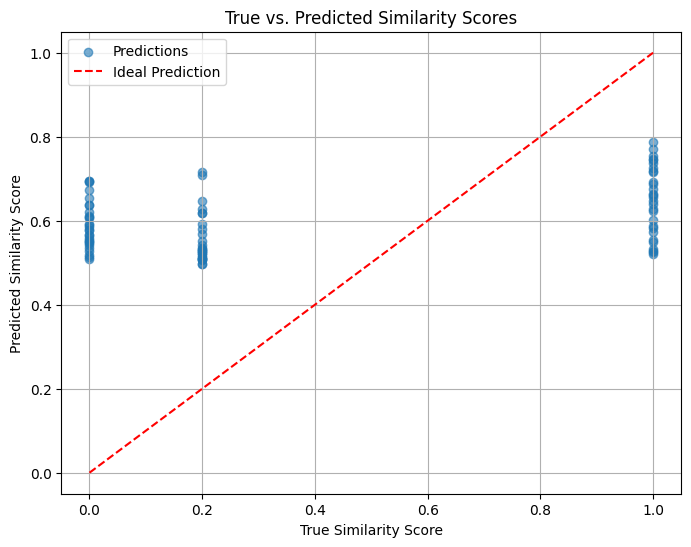

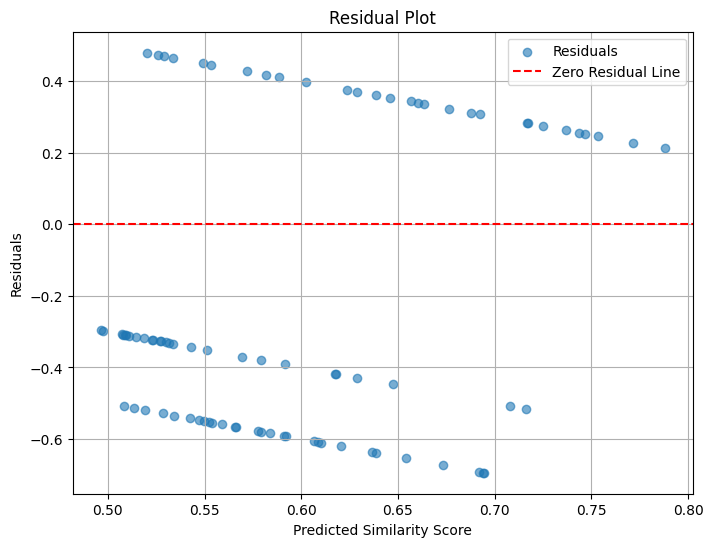

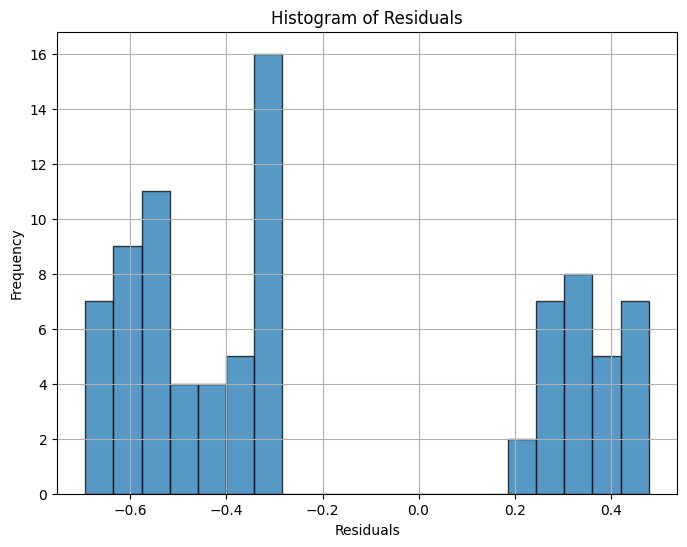

In [14]:
# Metrics calculation
mse = mean_squared_error(true_labels, predicted_scores)
mae = mean_absolute_error(true_labels, predicted_scores)
r2 = r2_score(true_labels, predicted_scores)

from scipy.stats import pearsonr, spearmanr

# Debug: Check true_labels and predicted_scores
print("True Labels:", true_labels[:10])
print("Predicted Scores:", predicted_scores[:10])

# Ensure Pearson and Spearman are scalar values
pearson_corr, _ = pearsonr(true_labels, predicted_scores)
spearman_corr, _ = spearmanr(true_labels, predicted_scores)

# Print metrics
print("Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Spearman Rank Correlation: {spearman_corr:.4f}")

# Visualization: Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_labels, predicted_scores, alpha=0.6, label="Predictions")
plt.plot([0, 1], [0, 1], "r--", label="Ideal Prediction")
plt.title("True vs. Predicted Similarity Scores")
plt.xlabel("True Similarity Score")
plt.ylabel("Predicted Similarity Score")
plt.legend()
plt.grid()
plt.show()

# Visualization: Residual Plot
residuals = true_labels - predicted_scores
plt.figure(figsize=(8, 6))
plt.scatter(predicted_scores, residuals, alpha=0.6, label="Residuals")
plt.axhline(0, color="red", linestyle="--", label="Zero Residual Line")
plt.title("Residual Plot")
plt.xlabel("Predicted Similarity Score")
plt.ylabel("Residuals")
plt.legend()
plt.grid()
plt.show()

# Visualization: Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, alpha=0.75, edgecolor="black")
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid()
plt.show()

### 4. Inference with the Fine-Tuned Model

In [15]:
# Single prompt and ground truth
prompt = "Breaking news: A significant breakthrough in AI technology!"
ground_truth = "AI technology has made a significant breakthrough in the field of robotics."
real_similarity = 1.0

# Tokenize the prompt
inputs = prompt + " => " + ground_truth
inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True, max_length=512)

model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Get the model's similarity score
with torch.no_grad():
    outputs = model(**inputs)
    predicted_similarity = torch.sigmoid(outputs.logits).item()  # Convert logits to probability

# Print results
print(f"Input Prompt: {prompt}")
print(f"Ground Truth: {ground_truth}")
print(f"Predicted Similarity Score: {predicted_similarity:.4f}")
print(f"Real Similarity Score: {real_similarity}")

# Optional: Compare predicted score with ground truth
error = abs(predicted_similarity - real_similarity)
print(f"Absolute Error: {error:.4f}")

Input Prompt: Breaking news: A significant breakthrough in AI technology!
Ground Truth: AI technology has made a significant breakthrough in the field of robotics.
Predicted Similarity Score: 0.7002
Real Similarity Score: 1.0
Absolute Error: 0.2998
